In [48]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm

# vit package - https://github.com/lucidrains/vit-pytorch
import vit_pytorch as vit

# custom packages
import src.commons.dataset as ds
import src.commons.constants as cons
from src.commons.modded_recorder import Recorder

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

# <span style="color:green">Vision Transformer so far</span>

We have tested ViT training with weak supervision in the notebook `nb_2_vision_transformer_tests.ipynb`. We also implemented a routine to pre-train ViTs in the TinyImagenet dataset (`nb_3_ViT_pretraining.ipynb`). Finally, we implemented a custom dataset in `src/commons/dataset.py` to tackle this weak supervision training.

Now, the goal is to:
1. Load data using the custom dataset
2. Load pretrained models
3. Fine tune them in the MVTec data
4. Inspect results
   1. Accuracy of "is anomaly" binary prediction
   2. Visualize segmentation masks extracted from attention
5. Use different patch sizes to obtain masks at different resolutions, and combine the results
6. Compare the ensemble results with the previous results


## Initialize data

Desired image transformations should be included in the `transforms.Compose` wrapper.

*Note:* what sort of data augmentation may be useful for our task?

*Note 2:* should we implement transforms only at the dataloader level?

In [2]:
# Load dataset
cat = "capsule"
transf = transforms.Compose([
    transforms.Resize((64, 64)), # Resize to match TinyImagenet resolution
    transforms.Lambda(lambda T: T.long()/255) # Convert image from 0-255 uint to 0-1 long
])
data = ds.MVTECViTDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), cat, transforms=transf)

# Split data into train/test/val
train_data, test_data, val_data = torch.utils.data.random_split(data, [0.8, 0.1, 0.1])

In [3]:
# Define DataLoaders for batching input
BATCH_SIZE = 16

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
def show_img_and_mask(img, mask, ex_name):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    ax1.imshow(torch.permute(img, (1, 2, 0)))
    ax1.set_title('Raw image')
    ax2.imshow(torch.permute(img, (1, 2, 0)))
    ax2.imshow(torch.permute(mask, (1, 2, 0)), cmap="spring", alpha=0.5, vmax=mask.max()/2)
    ax2.set_title('Ground truth mask')
    fig.suptitle(ex_name)
    plt.show()

In [5]:
for sample in data:
    if ('011' in sample['class_and_id']) and ('crack' in sample['class_and_id']):
        img1, mask1, ex_name1 = sample["inputs"], sample["ground_truth"], sample['class_and_id']
    elif ('010' in sample['class_and_id']) and ('faulty_imprint' in sample['class_and_id']):
        img2, mask2, ex_name2 = sample["inputs"], sample["ground_truth"], sample['class_and_id']

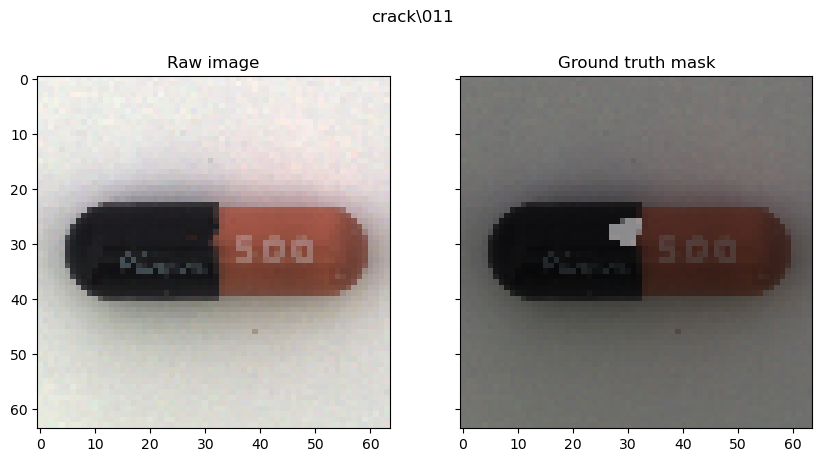

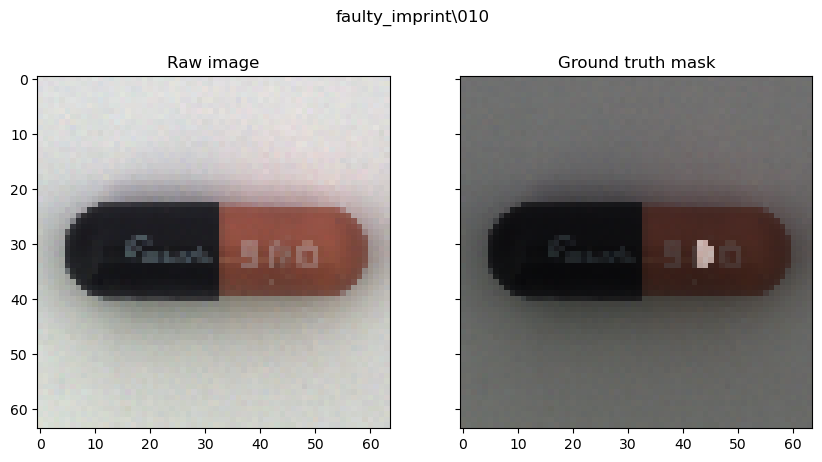

In [6]:
show_img_and_mask(img1, mask1, ex_name1)
show_img_and_mask(img2, mask2, ex_name2)

## Load pre-trained model

*Note: * what is the best way to handle hyper-parameter definition / storage?

In [74]:
# Pretrained model hyper-parameters
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
PATCH_SIZE = 4
HIDDEN_DIM = 256

# Load pretrained model
model = vit.SimpleViT(
    image_size = 64,
    patch_size = PATCH_SIZE,
    num_classes = 200,
    dim = HIDDEN_DIM,
    depth = 2,
    heads = 8,
    mlp_dim = 512
).to("cpu")

loaded = torch.load(os.path.join(CHECKPOINT_PATH, "simple_vit_pretrained_0.pt"))
print(f"Loaded model, epoch:{loaded['epoch']}, loss:{loaded['loss']}")
model.load_state_dict(loaded["model_state_dict"])

for p in model.parameters():
     p.requires_grad = False

model.linear_head[-1] = nn.Sequential(
    nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
    nn.ReLU(),
    nn.Linear(HIDDEN_DIM, 1)
)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_frozen_parameters(model):
    return sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Trainable params: {count_trainable_parameters(model)}")
print(f"Frozen params: {count_frozen_parameters(model)}")

model

Loaded model, epoch:16, loss:3.3293343412990386
Trainable params: 66049
Frozen params: 1589504


SimpleViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=48, out_features=256, bias=True)
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
          (to_out): Linear(in_features=512, out_features=256, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=256, out_features=512, bias=True)
            (2): GELU(approximate='none')
            (3): Linear(in_features=512, out_features=256, bias=True)
          )
        )
      )
      (1): ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_aff

## Fine tuning routine

In [75]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        inputs, targets = batch["inputs"], batch["labels"]
        inputs, targets = inputs.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits = model(inputs)
            preds = torch.sigmoid(logits)
            pred_cats = preds > 0.5
            acc = (pred_cats == targets).float().mean()
           
        loss = loss_fn(logits, targets.float())
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    num_epochs = kwargs.get("num_epochs", 100)

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(num_epochs):
        # Checkpoint if validation loss improves  
        if epoch > 2 and val_loss_hist[-2] > val_loss_hist[-1]:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss_hist[-1],
                    }, os.path.join(CHECKPOINT_PATH, "simple_vit_ft.pt"))

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            inputs, targets = batch["inputs"], batch["labels"]
            inputs, targets = inputs.to(device), targets.to(device)
    
            # print(f"Batch - Input: {inputs.shape, type(inputs), inputs.dtype} Target: {targets.shape, type(targets), targets.dtype}")

            model.zero_grad() # initialize gradients to zero
            logits = model(inputs) # forward pass

            # print(f"Logits - {logits.shape}, {type(logits)}, {logits.dtype}")

            loss = loss_fn(logits, targets.float()) # loss computation
            loss.backward() # computing gradients (backward pass)
            
            optimizer.step() # updating the parameters of the model
            # accuracy computation
            with torch.no_grad():
                preds = torch.sigmoid(logits)
                pred_cats = preds > 0.5
                acc = (pred_cats == targets).float().mean()
    
            # pop computational graph
            train_loss += loss.item()
            train_acc += acc.item() 
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
        

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc) 
        
        val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

In [76]:
# Define training parameters
LEARNING_RATE = 5e-5
NUM_EPOCHS = 20
print("BATCH SIZE: ", BATCH_SIZE)
print("CHECKPOINT PATH: ", CHECKPOINT_PATH)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) :.2e}")

# Define loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss()

# Attempt training on GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

# Send to device
model = model.to(DEVICE)
print(torch.cuda.memory_summary())

BATCH SIZE:  16
CHECKPOINT PATH:  ..\results
Total parameters: 6.60e+04
DEVICE: cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   66560 KB |  340903 KB |  432870 MB |  432805 MB |
|       from large pool |   31744 KB |  301056 KB |  428573 MB |  428542 MB |
|       from small pool |   34816 KB |   42124 KB |    4297 MB |    4263 MB |
|---------------------------------------------------------------------------|
| Active memory         |   66560 KB |  340903 KB |  4328

In [77]:
# Training
train_loss, val_loss, train_acc, val_acc = fit(model, train_dataloader, val_dataloader, optimizer,
                                               loss_fn=criterion, num_epochs=NUM_EPOCHS, device=DEVICE)


Epoch 1/20


loss = 0.684 | acc = 0.556: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]


Train loss: 0.703 | train acc = 0.500


loss = 0.640 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Validation loss: 0.603 | val acc = 0.764

Epoch 2/20


loss = 0.557 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Train loss: 0.636 | train acc = 0.668


loss = 0.631 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Validation loss: 0.560 | val acc = 0.764

Epoch 3/20


loss = 0.471 | acc = 0.889: 100%|██████████| 18/18 [00:10<00:00,  1.80it/s]


Train loss: 0.632 | train acc = 0.671


loss = 0.632 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Validation loss: 0.562 | val acc = 0.764

Epoch 4/20


loss = 0.878 | acc = 0.333: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s]


Train loss: 0.642 | train acc = 0.657


loss = 0.379 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation loss: 0.493 | val acc = 0.854

Epoch 5/20


loss = 0.633 | acc = 0.667: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Train loss: 0.633 | train acc = 0.666


loss = 0.432 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Validation loss: 0.521 | val acc = 0.854

Epoch 6/20


loss = 0.713 | acc = 0.556: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


Train loss: 0.635 | train acc = 0.663


loss = 0.877 | acc = 0.333: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Validation loss: 0.636 | val acc = 0.674

Epoch 7/20


loss = 0.800 | acc = 0.444: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]


Train loss: 0.635 | train acc = 0.660


loss = 0.402 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Validation loss: 0.501 | val acc = 0.854

Epoch 8/20


loss = 0.556 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Train loss: 0.629 | train acc = 0.668


loss = 0.635 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation loss: 0.567 | val acc = 0.764

Epoch 9/20


loss = 0.716 | acc = 0.556: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


Train loss: 0.632 | train acc = 0.663


loss = 0.635 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Validation loss: 0.562 | val acc = 0.764

Epoch 10/20


loss = 0.558 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


Train loss: 0.627 | train acc = 0.668


loss = 0.416 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Validation loss: 0.512 | val acc = 0.854

Epoch 11/20


loss = 0.460 | acc = 0.889: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Train loss: 0.624 | train acc = 0.671


loss = 0.639 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Validation loss: 0.565 | val acc = 0.764

Epoch 12/20


loss = 0.476 | acc = 0.889: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Train loss: 0.624 | train acc = 0.671


loss = 0.405 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation loss: 0.501 | val acc = 0.854

Epoch 13/20


loss = 0.554 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Train loss: 0.627 | train acc = 0.668


loss = 0.397 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


Validation loss: 0.500 | val acc = 0.854

Epoch 14/20


loss = 0.471 | acc = 0.889: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Train loss: 0.625 | train acc = 0.671


loss = 0.628 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation loss: 0.559 | val acc = 0.764

Epoch 15/20


loss = 0.605 | acc = 0.667: 100%|██████████| 18/18 [00:09<00:00,  1.80it/s]


Train loss: 0.625 | train acc = 0.666


loss = 0.387 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Validation loss: 0.493 | val acc = 0.854

Epoch 16/20


loss = 0.635 | acc = 0.667: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Train loss: 0.624 | train acc = 0.666


loss = 0.871 | acc = 0.333: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Validation loss: 0.626 | val acc = 0.674

Epoch 17/20


loss = 0.679 | acc = 0.556: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


Train loss: 0.625 | train acc = 0.663


loss = 0.404 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Validation loss: 0.501 | val acc = 0.854

Epoch 18/20


loss = 0.687 | acc = 0.556: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Train loss: 0.625 | train acc = 0.663


loss = 0.597 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Validation loss: 0.548 | val acc = 0.764

Epoch 19/20


loss = 0.704 | acc = 0.556: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Train loss: 0.623 | train acc = 0.663


loss = 0.413 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Validation loss: 0.508 | val acc = 0.854

Epoch 20/20


loss = 0.552 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Train loss: 0.621 | train acc = 0.668


loss = 0.404 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

Validation loss: 0.502 | val acc = 0.854


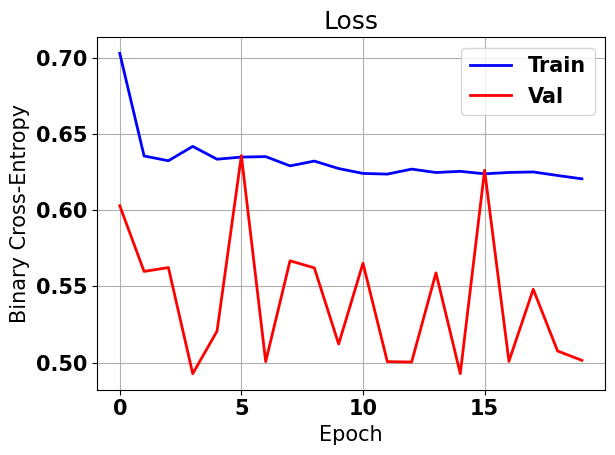

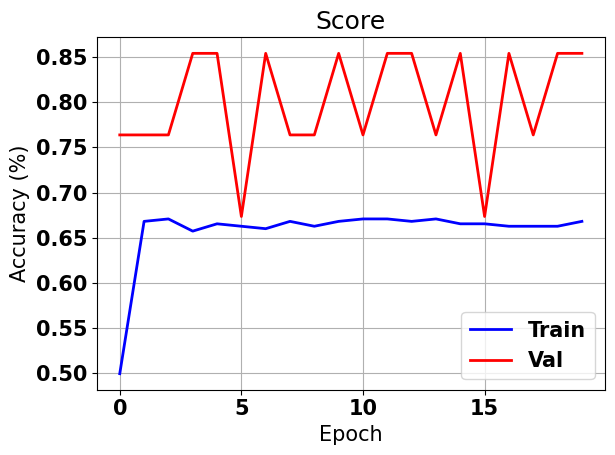

In [78]:
# Plot loss and accuracy
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    ####
    plt.figure()
    plt.title("Score")
    plt.plot(train_acc, lw=2.0, c="b", label="Train")
    plt.plot(val_acc, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [79]:
LEARNING_RATE = 1e-5
NUM_EPOCHS = 20

for p in model.parameters():
    p.requires_grad = True


print(f"Trainable params: {count_trainable_parameters(model)}")
print(f"Frozen params: {count_frozen_parameters(model)}")

Trainable params: 1655553
Frozen params: 0


In [80]:
# Training the complete model
temp1, temp2, temp3, temp4 = fit(model, train_dataloader, val_dataloader, optimizer,
                                 loss_fn=criterion, num_epochs=NUM_EPOCHS, device=DEVICE)

train_loss += temp1
val_loss += temp2
train_acc += temp3
val_acc += temp4



Epoch 1/20


loss = 0.676 | acc = 0.667: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


Train loss: 0.678 | train acc = 0.582


loss = 0.695 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Validation loss: 0.551 | val acc = 0.764

Epoch 2/20


loss = 0.585 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


Train loss: 0.654 | train acc = 0.668


loss = 0.631 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


Validation loss: 0.582 | val acc = 0.764

Epoch 3/20


loss = 0.558 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


Train loss: 0.635 | train acc = 0.668


loss = 0.448 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Validation loss: 0.526 | val acc = 0.854

Epoch 4/20


loss = 0.514 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


Train loss: 0.636 | train acc = 0.668


loss = 0.371 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Validation loss: 0.482 | val acc = 0.854

Epoch 5/20


loss = 0.582 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]


Train loss: 0.626 | train acc = 0.668


loss = 0.513 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Validation loss: 0.566 | val acc = 0.854

Epoch 6/20


loss = 0.642 | acc = 0.667: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


Train loss: 0.648 | train acc = 0.669


loss = 0.554 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Validation loss: 0.587 | val acc = 0.854

Epoch 7/20


loss = 0.589 | acc = 0.667: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Train loss: 0.632 | train acc = 0.683


loss = 0.639 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Validation loss: 0.542 | val acc = 0.764

Epoch 8/20


loss = 0.450 | acc = 1.000: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Train loss: 0.616 | train acc = 0.684


loss = 0.382 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


Validation loss: 0.488 | val acc = 0.854

Epoch 9/20


loss = 0.651 | acc = 0.556: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Train loss: 0.610 | train acc = 0.677


loss = 0.686 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Validation loss: 0.698 | val acc = 0.514

Epoch 10/20


loss = 0.565 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Train loss: 0.609 | train acc = 0.682


loss = 0.637 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Validation loss: 0.619 | val acc = 0.785

Epoch 11/20


loss = 0.550 | acc = 0.667: 100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


Train loss: 0.588 | train acc = 0.711


loss = 0.382 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Validation loss: 0.484 | val acc = 0.875

Epoch 12/20


loss = 0.613 | acc = 0.667: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Train loss: 0.563 | train acc = 0.718


loss = 0.449 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Validation loss: 0.518 | val acc = 0.833

Epoch 13/20


loss = 0.618 | acc = 0.667: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Train loss: 0.568 | train acc = 0.728


loss = 0.709 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Validation loss: 0.546 | val acc = 0.764

Epoch 14/20


loss = 0.566 | acc = 0.667: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


Train loss: 0.526 | train acc = 0.749


loss = 0.443 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Validation loss: 0.473 | val acc = 0.701

Epoch 15/20


loss = 0.461 | acc = 0.889: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Train loss: 0.519 | train acc = 0.779


loss = 0.917 | acc = 0.000: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Validation loss: 0.647 | val acc = 0.500

Epoch 16/20


loss = 0.394 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Train loss: 0.466 | train acc = 0.772


loss = 0.206 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Validation loss: 0.417 | val acc = 0.854

Epoch 17/20


loss = 0.262 | acc = 0.889: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Train loss: 0.512 | train acc = 0.740


loss = 0.799 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Validation loss: 0.590 | val acc = 0.764

Epoch 18/20


loss = 0.409 | acc = 0.889: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Train loss: 0.536 | train acc = 0.751


loss = 0.596 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Validation loss: 0.516 | val acc = 0.743

Epoch 19/20


loss = 0.526 | acc = 0.778: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


Train loss: 0.457 | train acc = 0.793


loss = 0.773 | acc = 0.667: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Validation loss: 0.579 | val acc = 0.764

Epoch 20/20


loss = 0.585 | acc = 0.667: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Train loss: 0.471 | train acc = 0.766


loss = 0.314 | acc = 1.000: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

Validation loss: 0.479 | val acc = 0.792


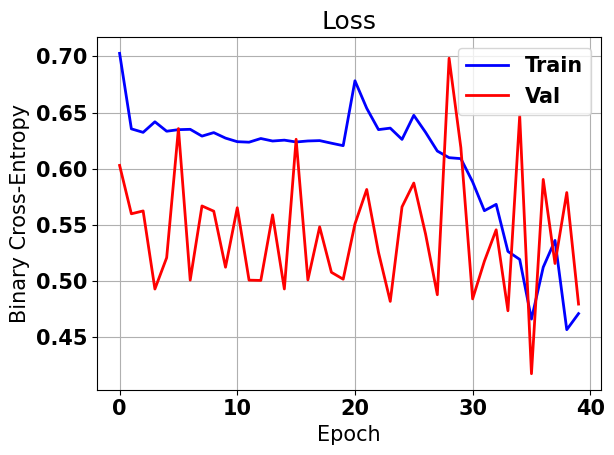

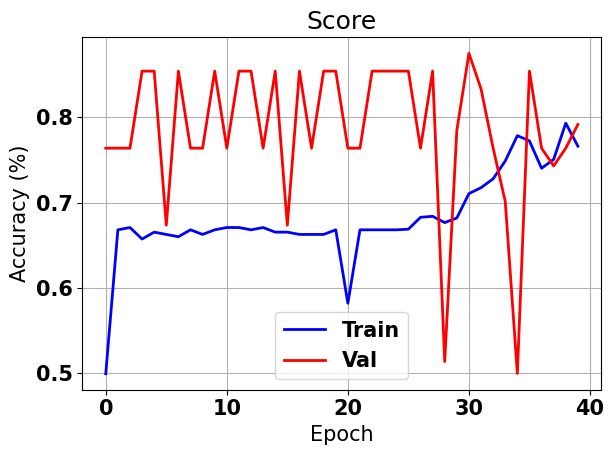

In [81]:
# Plot loss and accuracy
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    ####
    plt.figure()
    plt.title("Score")
    plt.plot(train_acc, lw=2.0, c="b", label="Train")
    plt.plot(val_acc, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [85]:
# Visualize attention layers
def predict_with_attention(model, data_loader, **kwargs):
    device = kwargs.get("device", torch.device("cpu"))

    images, labels, results, attn_weights = [], [], [], []

    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:

        data, targets = batch["inputs"], batch["labels"]
        data, targets = data.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits, attns = model(data) # attns: (batch x layers x heads x patch x patch)
            preds = torch.sigmoid(logits)
            pred_cats = preds > 0.5

        attns = attns.mean(dim=2) # average over heads
        attns_prod = attns[:, 0] # recursively multiply attentions
        for i in range(1, attns.shape[1]):
            attns_prod = torch.matmul(attns_prod, attns[:, i])

        images.append(data)
        labels.append(targets)
        results.append(pred_cats)
        attn_weights.append(attns_prod)

    images = torch.concat(tuple([image for image in images]), dim=0)
    labels = torch.concat(tuple([label for label in labels]))
    results = torch.concat(tuple([result for result in results]))
    attn_weights = torch.concat(tuple([attn for attn in attn_weights]))

    return images, labels, results, attn_weights

In [86]:
# Pretrained model hyper-parameters
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
PATCH_SIZE = 4
HIDDEN_DIM = 256

# Load pretrained model
model = vit.SimpleViT(
    image_size = 64,
    patch_size = PATCH_SIZE,
    num_classes = 200,
    dim = HIDDEN_DIM,
    depth = 2,
    heads = 8,
    mlp_dim = 512
).to("cpu")


model.linear_head[-1] = nn.Sequential(
    nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
    nn.ReLU(),
    nn.Linear(HIDDEN_DIM, 1)
)

loaded = torch.load(os.path.join(CHECKPOINT_PATH, "simple_vit_ft.pt"))
print(f"Loaded model, epoch:{loaded['epoch']}, loss:{loaded['loss']}")
model.load_state_dict(loaded["model_state_dict"])


model = Recorder(model) # set up model to return attention weights in forward pass
images, labels, pred_cats, attns = predict_with_attention(model, test_dataloader)
model = model.eject() # remove hooks from forward pass


print(images.shape, labels.shape, pred_cats.shape, attns.shape)

Loaded model, epoch:18, loss:0.5155863563219706


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

torch.Size([35, 3, 64, 64]) torch.Size([35, 1]) torch.Size([35, 1]) torch.Size([35, 256, 256])


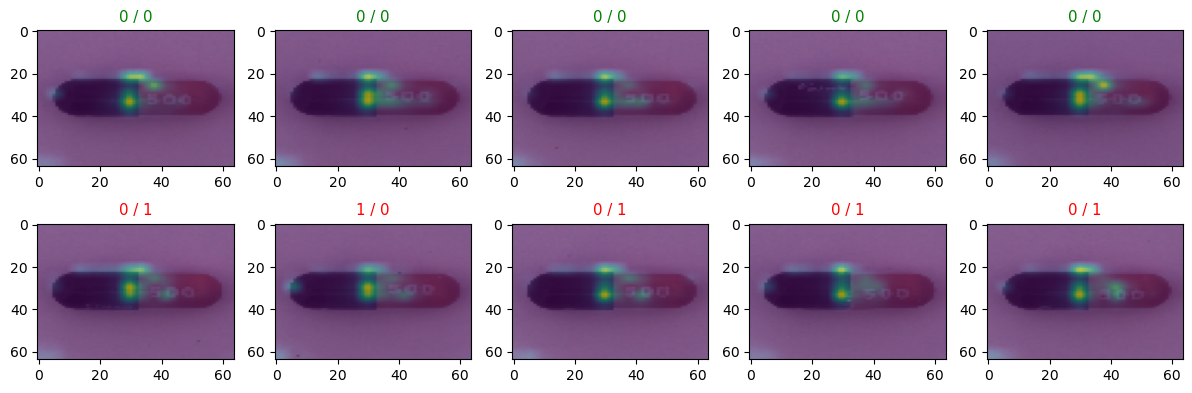

In [87]:
%matplotlib inline
# Refs: https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map/notebook

corrects = torch.eq(labels, pred_cats).squeeze()
wrongs = ~corrects

fig, ax = plt.subplots(2, 5, figsize=(12, 4))
with plt.rc_context(rc={'font.size': 9}):
    for i in range(5): 
        # Plot correct predictions
        img = images[corrects][i]
        img_label = labels[corrects][i]
        pred_label = pred_cats[corrects][i]
        resize = transforms.Resize((64, 64))
        
        attns_raw = attns[corrects][i]
        attns_vals = attns_raw[-1]
        mask = attns_vals.reshape(16, 16)
        mask = resize(mask.unsqueeze(0)).squeeze()
        mask = mask.detach().numpy()
        mask = (mask - mask.min())/(mask.max() - mask.min())

        img_perm = torch.permute(img, (1, 2, 0)).cpu().numpy()
        ax[0, i].imshow(img_perm, aspect="auto")
        ax[0, i].imshow(mask, aspect="auto", alpha=0.6, cmap="viridis")
    
        ax[0, i].set_title(f"{pred_label.int().item()} / {img_label.item()}", color="green")

        # Plot wrong predictions
        img = images[wrongs][i]
        img_label = labels[wrongs][i]
        pred_label = pred_cats[wrongs][i]
        resize = transforms.Resize((64, 64))
        
        attns_raw = attns[wrongs][i]
        attns_vals = attns_raw[-1]
        mask = attns_vals.reshape(16, 16)
        mask = resize(mask.unsqueeze(0)).squeeze()
        mask = mask.detach().numpy()
        mask = (mask - mask.min())/(mask.max() - mask.min())

        img_perm = torch.permute(img, (1, 2, 0)).cpu().numpy()
        ax[1, i].imshow(img_perm, aspect="auto")
        ax[1, i].imshow(mask, aspect="auto", alpha=0.6, cmap="viridis")

        ax[1, i].set_title(f"{pred_label.int().item()} / {img_label.item()}", color="red")

    fig.tight_layout()